In [1]:
from reweight_functions import *
import pickle

### SETTING THE DIRECTORIES TO THE EXPERIMENTAL, COMPUTED DATA AND MAKING DIRECTORIES FOR THE OUTPUT AND FOR SAVING THE REWEIGHTED RMSES AS DICTIONARIES IN THEIR OWN DIRECTORIES

In [2]:
main_path = '/Users/kaushikborthakur1211/Desktop/Paper_Repo/PaaA2'

outdir = os.path.join(main_path, 'a99SBdisp', 'reweight_trial')
datadir = os.path.join(main_path, 'a99SBdisp', 'Average_Data')
expdatadir = os.path.join(main_path, 'Exp_Data')
weights_dir = os.path.join(outdir, 'weights')

if not os.path.exists(outdir):
    os.makedirs(outdir)
if not os.path.exists(weights_dir):
    os.makedirs(weights_dir)

single_dir = os.path.join(weights_dir + "/single_data")
if not os.path.exists(single_dir):
    os.makedirs(single_dir)
leave_dir = os.path.join(weights_dir + "/leave_one_data")
if not os.path.exists(leave_dir):
    os.makedirs(leave_dir)
combined_dir = os.path.join(weights_dir + "/combined_data")
if not os.path.exists(combined_dir):
    os.makedirs(combined_dir)

dic_dir = os.path.join(outdir, 'dictionaries')
if not os.path.exists(dic_dir):
    os.makedirs(dic_dir)


### SETTING THE REWEIGHTING KEYS (DATA TYPES TO USE IN THE REWEIGHTING PROCEDURE)

In [3]:
chemical_shifts = ['CB', 'HA', 'CA', 'H', 'N', 'C']

colors = {'C': 'royalblue', 'HA': 'orange', 'CA': 'red', 'CB': 'forestgreen', 'H': 'mediumorchid',
            'N': 'darkslateblue', 'JHNHA': 'cornflowerblue', 'Rg': 'grey', 'RDC': 'firebrick', 'SAXS': 'teal',
            'Tot': 'black'}

theta_0 = {'HA': 1., 'CA': 1, 'CB': 1., 'C': 1., 'H': 1., 'HA2': 1., 'HA3': 1., 'N': 1., 'RDC': 1., 'Rg': 1.,
            'JHNHA': 1., 'SAXS': 1.}

to_remove = ['HA2', 'HA3']
reweighting_keys = ['CA', 'CB', 'HA', 'H', 'N', 'C', 'RDC', 'SAXS']


print('Main settings:\n')
print('Reweighting keys: {}'.format(reweighting_keys))


Main settings:

Reweighting keys: ['CA', 'CB', 'HA', 'H', 'N', 'C', 'RDC', 'SAXS']


### LOADING THE EXPERIMENTAL AND COMPUTED DATA.

### Data Parsing Functions

These functions read files and organize the data into nested dictionary structures. 

#### Function: `read_cs_md(data)`/`read_exp_cs(data)`

- **Input:** A file path to a comma-separated values (CSV) file for chemical shifts/PREs/SAXS profiles.
- **Output:** A nested dictionary with keys (`'HA'`, `'CA'`, `'CB'`, etc.) corresponding to a data-type, where:
  - The first element of each line is used as an inner dictionary key which could be a residue number for shifts or scattering angle for SAXS etc.
  - The values are numpy arrays of floats corresponding to the time-series data from simulation or the ensemble average experimental data.

#### Function: `Align_Comp_Exp_Data`

- **Input:** The compdata and expdata dictionaries we generate from function above.

- **Output:** New updated dictionaries for both such that they have information for common residue numbers/scattering angles etc. This is useful when the experimental data you have has information missing for certain residues but the computed shifts from SPARTA+ has time-series data for every residue.

In [7]:
expdata = read_exp_cs(join(expdatadir, 'CS.exp.dat'))
compdata = read_cs_md(join(datadir, 'chemical_shifts.all.csv'), )

expdata = add_exp_data(join(expdatadir, 'RDC.exp.dat'), expdata, 'RDC')
compdata = add_md_data(join(datadir, 'RDC.all.csv'), compdata, 'RDC')


expdata = add_exp_data(expdatadir + '/SAXS.exp.dat', expdata, 'SAXS')
compdata = add_md_data(datadir + '/SAXS.csv', compdata, 'SAXS')

# Remove the '# drho = 3.34 ; r0 = 1.68' entry from compdata['SAXS']
compdata['SAXS'].pop('# drho = 3.34 ; r0 = 1.68', None)

# Replace each key in compdata['SAXS'] with the corresponding key from expdata['SAXS']
new_compdata_saxs = {}
for exp_key, comp_key in zip(expdata['SAXS'].keys(), compdata['SAXS'].keys()):
    new_compdata_saxs[exp_key] = compdata['SAXS'][comp_key]

# Replace the original compdata['SAXS'] with the new dictionary
compdata['SAXS'] = new_compdata_saxs


# Elimination of compdata that are not in expdata and viceversa
compdata, expdata = Align_Comp_Exp_Data(compdata, expdata)


nframes = len(compdata[list(compdata.keys())[1]][list(compdata[list(compdata.keys())[1]].keys())[0]])

# labels
exp_labels = list(compdata.keys())
true_exp_labels = [key for key in exp_labels if key not in to_remove]

print(
    'Correctely acquired data from experiments and for MD simulations for the following quantities:\n{}\nNumber of frames = {}'.format(
        [str(key) for key in compdata.keys()], nframes))

Correctely acquired data from experiments and for MD simulations for the following quantities:
['HA', 'CA', 'CB', 'C', 'H', 'HA2', 'HA3', 'N', 'RDC', 'SAXS']
Number of frames = 29976


### Reweighting and Validation Procedure

This code block initializes the reweighting process by putting the reweighting keys information in dictionaries.

#### Initialization
- `sd`: Dictionary to store standard deviations.
- `To_Scan`: List of keys to process for reweighting.

#### Separation of Data
- **Separate Reweight and Validation Data:**
 This function separates the input `CS` items and `true_exp_labels` into two distinct sets: `Reweight_Data` and `Validation_Data`.
 - **Inputs:**
  - `CS`: Can be a single key or list of keys.
  - `true_exp_labels`: A list of labels for the data-types used.

- **Outputs:**
  - `CS`: A string representation of the `CS` keys.
  - `Reweight_Data`: A list of keys (data-types) that need reweighting.
  - `Validation_Data`: A list of validation items, which are the remaining items in `true_exp_labels` after removing `CS` items.

#### Function: `Process_Data_Into_Arrays(data, expdata, compdata, err_d, compare_dict)`

- **Inputs:**
  - `data`: List of keys representing either Reweight_Data or Validation_Data.
  - `expdata`: Dictionary of experimental data.
  - `compdata`: Dictionary of computed MD timeseries data.
  - `err_d`: Dictionary of regularization parameter values which are all initialized at 1.0 for each data-type.
  - `compare_dict`: Dictionary to store comparison data.

- **Outputs:**
  - `exp`: Numpy array of experimental values.
  - `traj`: Numpy array of MD timeseries data.
  - `data_t`: List of data types (keys) (either r for reweight or v for validation).
  - `data_type`: Dictionary mapping keys to boolean arrays indicating the presence of data.
  - `compare_dict`: Updated comparison dictionary.


In [8]:
sd = {}
To_Scan = reweighting_keys
for CS in To_Scan:
    CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
    print('Reweight Data = {}'.format(CS))
    print('Validation Data = {}'.format(Validation_Data))

    ### debugging variables
    compare = []
    compare_dict_r = {key: {} for key in compdata.keys()}
    compare_dict_v = {key: {} for key in compdata.keys()}

    ####### B) The reweighting procedure

    # i) Process Reweight data into arrays 
    obs_exp_r, traj_r, err_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays(Reweight_Data,
                                                                                                expdata, compdata,
                                                                                                theta_0,
                                                                                                compare_dict_r)

    # ii) Process Validation data into arrays 
    obs_exp_v, traj_v, err_v, data_v_t, data_v_type, compare_dict_v = Process_Data_Into_Arrays(Validation_Data,
                                                                                                expdata, compdata,
                                                                                                theta_0,
                                                                                                compare_dict_v)

    # final_weights

    for key in data_v_type:
        print(key)
        res = []
        md_ave = []
        sigmas = []
        exp = []
        sd[key] = {}
        for key2 in compare_dict_v[key]:
            timeseries = compare_dict_v[key][key2][1]
            uniform_weights = np.ones(len(timeseries))
            dim = 5000
            A, W = Weighted_Independent_Blocks(timeseries, uniform_weights, dim, verbose=False)
            ave = np.average(A, weights=W)
            sigma = Weighted_Sigma_of_Mean(A, W)
            sd[key][key2] = np.array([float(key2), float(compare_dict_v[key][key2][0]), float(ave), float(sigma)])

    for key in data_r_type:
        print(key)
        res = []
        md_ave = []
        sigmas = []
        exp = []
        sd[key] = {}
        for key2 in compare_dict_r[key]:
            timeseries = compare_dict_r[key][key2][1]
            uniform_weights = np.ones(len(timeseries))
            dim = 5000
            A, W = Weighted_Independent_Blocks(timeseries, uniform_weights, dim, verbose=False)
            ave = np.average(A, weights=W)
            sigma = Weighted_Sigma_of_Mean(A, W)
            sd[key][key2] = np.array([float(key2), float(compare_dict_r[key][key2][0]), float(ave), float(sigma)])

Reweight Data = CA
Validation Data = ['HA', 'CB', 'C', 'H', 'N', 'RDC', 'SAXS']
HA
CB
C
H
N
RDC
SAXS
CA
Reweight Data = CB
Validation Data = ['HA', 'CA', 'C', 'H', 'N', 'RDC', 'SAXS']
HA
CA
C
H
N
RDC
SAXS
CB
Reweight Data = HA
Validation Data = ['CA', 'CB', 'C', 'H', 'N', 'RDC', 'SAXS']
CA
CB
C
H
N
RDC
SAXS
HA
Reweight Data = H
Validation Data = ['HA', 'CA', 'CB', 'C', 'N', 'RDC', 'SAXS']
HA
CA
CB
C
N
RDC
SAXS
H
Reweight Data = N
Validation Data = ['HA', 'CA', 'CB', 'C', 'H', 'RDC', 'SAXS']
HA
CA
CB
C
H
RDC
SAXS
N
Reweight Data = C
Validation Data = ['HA', 'CA', 'CB', 'H', 'N', 'RDC', 'SAXS']
HA
CA
CB
H
N
RDC
SAXS
C
Reweight Data = RDC
Validation Data = ['HA', 'CA', 'CB', 'C', 'H', 'N', 'SAXS']
HA
CA
CB
C
H
N
SAXS
RDC
Reweight Data = SAXS
Validation Data = ['HA', 'CA', 'CB', 'C', 'H', 'N', 'RDC']
HA
CA
CB
C
H
N
RDC
SAXS


### INITIAL ROUND OF REWEIGHTING FOR A RANGE OF SIGMA_REG VALUES FOR EACH INDIVIDUAL DATA TYPE

### Reweighting Procedure with range of Regularization Parameters for one data-type at a time

This code performs a reweighting procedure over a range of regularization parameters (`thetas`) to evaluate the impact on root mean square error (RMSE) and Kish effective size.

#### Initialization
- **Variables:**
  - `To_Scan`: List of keys for reweighting.
  - `thetas`: Array of regularization parameters.
  - `ref_theta`: Reference value from `thetas`.
  - `RMSE_dict`: Dictionary to store RMSE values.
  - `KishScan_one_data`: Dictionary to store Kish effective size data.

#### Separation of Data
For each key in `To_Scan`:
- **Separate Reweight and Validation Data:**
- **Process_Data_Into_Arrays_with_sigma:** (store the information in dictionaries and calculate $/sigma_{MD}$ with block analysis)
- **Perform reweighting process per regularization value per data-type and minimize using L-BFGS algorithm**

For each data-type and iteration:

- **RMSEs and Kish values are calculated:**
  - **Kish Effective Size** (`Kish_ratio`): Measures the effective sample size after reweighting.
  - **RMSE (Root Mean Square Error):**
    - `RMSE_r_i`: Initial RMSE for Reweight Data.
    - `RMSE_r_f`: Final RMSE for Reweight Data.
    - `RMSE_v_i`: Initial RMSE for Validation Data.
    - `RMSE_v_f`: Final RMSE for Validation Data.

- **Results are stored in dictionaries:**
  - `RMSE_dict[CS][s]`: Stores Kish effective size and RMSE values for each regularization parameter (`theta_m`).
  - `KishScan_one_data[CS]`: Stores the list of `theta` values and their corresponding Kish effective sizes and final RMSE values for further analysis.




### Applying our Reweighting Theory Here

```python
def func_sigma_reg_sigma_md(l, traj_r, obs_exp_r, weight_bias, sigma_reg, sigma_md):
    l = np.array(l)  
    weight_all = +weight_bias  
    weight_all -= np.dot(l, traj_r)  
    shift_all = np.max(weight_all)  
    weight_all = np.exp(weight_all - shift_all)  
    weight_0 = +weight_bias  
    shift_0 = np.max(weight_0)  
    weight_0 = np.exp(weight_0 - shift_0)  

    # Gamma/Lagrange function in maxent:
    # Shifts to avoid overflows
    f = np.log(np.sum(weight_all) / np.sum(weight_0)) + shift_all - shift_0 + np.dot(l, obs_exp_r)

    # Derivative of Gamma function:
    der = obs_exp_r - np.dot(traj_r, weight_all) / np.sum(weight_all)  # Derivative with respect to l

    f += 0.5 * np.sum((sigma_reg * sigma_reg) * l ** 2 + sigma_md * sigma_md * l ** 2)
    der += sigma_reg * sigma_reg * l + sigma_md * sigma_md * l
    return f, der




Gamma function in the code refers to the following:
$$
 \mathcal{L} = D_{KL}[P_1|P_0]  - \sum_{i=1}^M \lambda_i \left [ \int P_1(x) f_i(x) dx - f_i^{\text{exp}} \right ] - \mu \left [ \int P_1 (x) dx - 1 \right ] 
$$
Derivative of the function is the following:
$$
\frac{\delta \mathcal{L}}{\delta P_1} = -\ln \frac{P_1}{P_0} - 1 - \sum_{i=1}^{M} \lambda_i f_i(\mathbf{x}) - \mu
$$
 The $\sigma$ values for reweighting is given by:
$$
\sigma_{i} = \sqrt{\sigma_{i,\text{MD}}^2 + \sigma_{\text{reg}}^2}
$$






In [9]:
To_Scan = reweighting_keys
thetas = np.linspace(0.001, 20, 200)
ref_theta = thetas[-1]
RMSE_dict = {}
KishScan_one_data = {}


for CS in To_Scan:
        CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
        KishScan_one_data[CS] = {}
        print('Reweight Data = {}'.format(CS))
        RMSE_dict[CS] = {}

        ### debugging variables
        compare = []
        compare_dict_r = {key: {} for key in compdata.keys()}
        compare_dict_v = {key: {} for key in compdata.keys()}

        ####### B) The reweighting procedure

        obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(
            Reweight_Data, expdata, compdata, theta_0, sd, compare_dict_r)
        obs_exp_v, traj_v, err_v, sigma_md_v, data_v_t, data_v_type, compare_dict_v = Process_Data_Into_Arrays_with_sigma(
            Validation_Data, expdata, compdata, theta_0, sd, compare_dict_v)

        # THETA CYCLE
        theta_list = []
        kish_list = []
        rmsd_f_list = []
        for theta_m in np.flip(thetas):

            s = '{:.2f}'.format(theta_m)
            # print(s)
            sigma_reg = theta_m * err_r
            sigma_md = sigma_md_r
            RMSE_dict[CS][s] = {}

            # iv) Print dimensions
            nobs_r = len(obs_exp_r)
            nobs_v = len(obs_exp_v)
            # Print_Number_of_Data(nframes, nobs_r, nobs_v, data_r_type, data_v_type)

            # v) perform minimization
            # OBS: res.X = lagrange multiplier
            weight_bias = np.ones(nframes)

            if 'RDC' in Reweight_Data:
                initial_weights = weight_bias
                initial_weights /= np.sum(initial_weights)
                initial_obs_r = np.dot(traj_r, initial_weights)
                initial_obs_r
                exp_rdc = np.trim_zeros(obs_exp_r * data_r_type['RDC'])
                calc_rdc = np.trim_zeros(initial_obs_r * data_r_type['RDC'])
                qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
                qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

                if (qf_neg < qf_pos):
                    c = -c_neg
                else:
                    c = c_pos

                RDC_rows = np.where(data_r_type['RDC'] == 1)
                traj_r[RDC_rows] = traj_r[RDC_rows] * c

            if 'RDC' in Validation_Data:
                initial_weights = weight_bias
                initial_weights /= np.sum(initial_weights)
                initial_obs_v = np.dot(traj_v, initial_weights)
                exp_rdc = np.trim_zeros(obs_exp_v * data_v_type['RDC'])
                calc_rdc = np.trim_zeros(initial_obs_v * data_v_type['RDC'])
                qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
                qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

                if (qf_neg < qf_pos):
                    c = -c_neg
                else:
                    c = c_pos

                RDC_rows = np.where(data_v_type['RDC'] == 1)
                traj_v[RDC_rows] = traj_v[RDC_rows] * c

            res = sp.optimize.minimize(func_sigma_reg_sigma_md,
                                       args=(traj_r, obs_exp_r, weight_bias, sigma_reg, sigma_md),
                                       x0=np.zeros((nobs_r,)), method='L-BFGS-B', jac=True)
            initial_weights = Normalize_Weights(weight_bias)
            initial_obs_r = np.dot(traj_r, initial_weights)
            initial_obs_v = np.dot(traj_v, initial_weights)

            final_weights = Normalize_Weights(weight_bias - np.dot(res.x, traj_r))
            final_obs_r = np.dot(traj_r, final_weights)
            final_obs_v = np.dot(traj_v, final_weights)
            # g) calculating Kish effective size
            Ks_b = np.average(initial_weights) ** 2 / np.average(initial_weights ** 2)
            Ks_a = np.average(final_weights) ** 2 / np.average(final_weights ** 2)

            Kish_ratio = (Ks_a / Ks_b) * 100
            RMSE_initial = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))
            RMSE_reweight = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))

            theta_list.append(theta_m)
            kish_list.append(Kish_ratio)
            rmsd_f_list.append(RMSE_reweight)
            RMSE_r_i = {}
            RMSE_v_i = {}
            RMSE_r_f = {}
            RMSE_v_f = {}
            RMSE_r_i['Tot'] = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))

            for t in data_r_type:
                RMSE_r_i[t] = np.sqrt(
                    np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
                if str(t) == 'RDC':
                    qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_r * data_r_type['RDC'],
                                                                       obs_exp_r * data_r_type['RDC'])
                    RMSE_r_i['RDC'] = qf

            RMSE_v_i['Tot'] = np.sqrt(
                np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
            for t in data_v_type:
                RMSE_v_i[t] = np.sqrt(
                    np.sum((initial_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t]))
                if str(t) == 'RDC':
                    qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_v * data_v_type['RDC'],
                                                                       obs_exp_v * data_v_type['RDC'])
                    RMSE_v_i['RDC'] = qf

            RMSE_r_f['Tot'] = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))

            for t in data_r_type:
                RMSE_r_f[t] = np.sqrt(np.sum((final_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
                if str(t) == 'RDC':
                    qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(final_obs_r * data_r_type['RDC'],
                                                                       obs_exp_r * data_r_type['RDC'])
                    RMSE_r_f['RDC'] = qf

            for t in data_v_type:
                RMSE_v_f[t] = np.sqrt(np.sum((final_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t]))
                if str(t) == 'RDC':
                    qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(final_obs_v * data_v_type['RDC'],
                                                                       obs_exp_v * data_v_type['RDC'])
                    RMSE_v_f['RDC'] = qf

            RMSE_dict[CS][s]['Kish'] = Kish_ratio
            RMSE_dict[CS][s]['r_i'] = RMSE_r_i
            RMSE_dict[CS][s]['r_f'] = RMSE_r_f
            RMSE_dict[CS][s]['v_i'] = RMSE_v_i
            RMSE_dict[CS][s]['v_f'] = RMSE_v_f

        KishScan_one_data[CS]['kish'] = np.column_stack((theta_list, kish_list))
        KishScan_one_data[CS]['rmsd'] = np.column_stack((theta_list, rmsd_f_list))

Reweight Data = CA
Reweight Data = CB
Reweight Data = HA
Reweight Data = H
Reweight Data = N
Reweight Data = C
Reweight Data = RDC
Reweight Data = SAXS


### Finding Optimal Regularization Parameter

This code iterates through `KishScan_one_data` to find a `theta_m` that meets a minimum Kish ratio (`kish_min`). It selects the last `theta_m` value above `kish_min` and, if zero, uses the second-to-last value.

#### Process:
- **Initialization:**
  - `kish_min = 10`: Minimum threshold for the Kish ratio.
  - `theta_dict`: Dictionary to store selected `theta_m` values for each `key` in `KishScan_one_data`.
  - `Kish_ratio_vals`: List to collect `theta_m` values meeting the `kish_min` criteria.

- **Iteration:**
  - For each `key` in `KishScan_one_data`:
    - Retrieve Kish ratios (`kish`) from `KishScan_one_data[key]['kish']`.
    - Identify indices (`b`) where Kish ratio meets or exceeds `kish_min`.
    - Select `theta_m` as the last valid value (so lowest value) from `kish` that meets the criteria.
    - If `theta_m` is zero, fallback to the second-to-last valid value (`k[idy][0]`).
    - Store `theta_m` in `theta_dict[key]`.

- **Output:**
  - `theta_dict`: Dictionary mapping each key to the selected `theta_m` that meets the `kish_min` criteria.


In [13]:
kish_min = 10
theta_dict = {}
Kish_ratio_vals = []
for key in KishScan_one_data:
    k = KishScan_one_data[key]['kish']
    b = (np.where(k[:, 1] >= kish_min))[0]
    idx = b[-1]
    idy = b[-2]
    theta_m = k[idy][0]
    Kish_ratio_vals.append(theta_m)
    # if (theta_m == 0):
    #     theta_m = k[idy][0]
    theta_dict[key] = {}
    theta_dict[key] = (theta_m)


In [11]:
def print_results():
    print(CS, "Theta:", theta_m, "Kish: %9.6lf" % (Kish_ratio), "RMSD initail: %0.4f" % RMSE_initial,
            "RMSD final: %0.4f" % RMSE_reweight)

    print("Initial RMSE reweight data ")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2)))

    for t in data_r_type:
        print(" *    %2s :" % t, end='')
        print("     %6.3lf" % np.sqrt(
            np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t])))

        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_r * data_r_type['RDC'],
                                                                obs_exp_r * data_r_type['RDC'])

            print(" *    RDC scaled Q:", end='')
            print(" %6.3lf" % qf)

    print("Initial RMSE validation data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_v - obs_exp_v) ** 2)))

    for t in data_v_type:
        print(" *    %2s :" % t, end='')
  
        print("     %6.3lf" % np.sqrt(
            np.sum((initial_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t])))
        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_v * data_v_type['RDC'],
                                                                obs_exp_v * data_v_type['RDC'])
 
            print(" *    RDC scaled Q:", end='')
            print(" %6.3lf" % qf)

    print("Final RMSE reweight data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2)))

    for t in data_r_type:
        print(" *    %2s :" % t, end='')
        print("     %6.3lf" % np.sqrt(
            np.sum((final_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t])))
        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdcs_scale_f, c = scale_rdc_Q(final_obs_r * data_r_type['RDC'],
                                                                obs_exp_r * data_r_type['RDC'])

            print(" *    RDC Q_scaled:", end='')
            print(" %6.3lf" % qf)

    print("Final RMSE validation data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_v - obs_exp_v) ** 2)))

    for t in data_v_type:
        print(" *    %2s :" % t, end='')
        print("     %6.3lf" % np.sqrt(
            np.sum((final_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t])))
        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdc_scale_f, c = scale_rdc_Q(final_obs_v * data_v_type['RDC'],
                                                                obs_exp_v * data_v_type['RDC'])
           
            print(" *    RDC Q_scaled:", end='')
            print(" %6.3lf" % qf)


### Reweighting Individual Data-Types based on optimal regularization parameter as found above
- We found optimal regularization paramters as discussed above
- We run the same reweighting process on each data type for it's own optimal regularization parameter instead of iterating over a range of values

In [14]:
To_Scan = reweighting_keys

for CS in To_Scan:
    CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
    print('Reweight Data = {}'.format(CS))
    CS_dir = join(single_dir, CS)
    if not os.path.exists(CS_dir):
        os.makedirs(CS_dir)

    compare = []
    compare_dict_r = {key: {} for key in compdata.keys()}
    compare_dict_v = {key: {} for key in compdata.keys()}

    obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(
        Reweight_Data, expdata, compdata, theta_dict, sd, compare_dict_r)
    obs_exp_v, traj_v, err_v, sigma_md_v, data_v_t, data_v_type, compare_dict_v = Process_Data_Into_Arrays_with_sigma(
        Validation_Data, expdata, compdata, theta_0, sd, compare_dict_v)

    theta_m = theta_dict[CS]
    s = '{:.2f}'.format(theta_m)
    print(s)
    sigma_reg = theta_m
    #sigma_md = sigma_md_r
    sigma_md = np.zeros(len(sigma_md_r))

    # iv) Print dimensions
    nobs_r = len(obs_exp_r)
    nobs_v = len(obs_exp_v)

    # v) perform minimization
    # OBS: res.X = lagrange multiplier
    weight_bias = np.ones(nframes)
    if 'RDC' in Reweight_Data:
        intial_weights = weight_bias
        initial_weights /= np.sum(initial_weights)
        initial_obs_r = np.dot(traj_r, initial_weights)
        initial_obs_r
        exp_rdc = np.trim_zeros(obs_exp_r * data_r_type['RDC'])
        calc_rdc = np.trim_zeros(initial_obs_r * data_r_type['RDC'])
        qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
        qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

        if (qf_neg < qf_pos):
            c = -c_neg
        else:
            c = c_pos
        RDC_rows = np.where(data_r_type['RDC'] == 1)
        traj_r[RDC_rows] = traj_r[RDC_rows] * c

    if 'RDC' in Validation_Data:
        intial_weights = weight_bias
        initial_weights /= np.sum(initial_weights)
        initial_obs_v = np.dot(traj_v, initial_weights)
        initial_obs_v
        exp_rdc = np.trim_zeros(obs_exp_v * data_v_type['RDC'])
        calc_rdc = np.trim_zeros(initial_obs_v * data_v_type['RDC'])
        qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
        qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

        if (qf_neg < qf_pos):
            c = -c_neg
        else:
            c = c_pos
        RDC_rows = np.where(data_v_type['RDC'] == 1)
        traj_v[RDC_rows] = traj_v[RDC_rows] * c

    res = sp.optimize.minimize(func_sigma_reg_sigma_md, args=(traj_r, obs_exp_r, weight_bias, sigma_reg, sigma_md),
                                x0=np.zeros((nobs_r,)), method='L-BFGS-B', jac=True)
    initial_weights = Normalize_Weights(weight_bias)
    initial_obs_r = np.dot(traj_r, initial_weights)
    initial_obs_v = np.dot(traj_v, initial_weights)
    final_weights = Normalize_Weights(weight_bias - np.dot(res.x, traj_r))
    # e) final average observables for reweighting and validation
    final_obs_r = np.dot(traj_r, final_weights)
    final_obs_v = np.dot(traj_v, final_weights)
    # g) calculating Kish effective size
    Ks_b = np.average(initial_weights) ** 2 / np.average(initial_weights ** 2)
    Ks_a = np.average(final_weights) ** 2 / np.average(final_weights ** 2)
    Kish_ratio = (Ks_a / Ks_b) * 100
    RMSE_initial = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))
    RMSE_reweight = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))
    print_results()

   
    np.savetxt('%s/weights_final.dat' % (CS_dir), final_weights, fmt=" %6.12lf")
    # print final weights to file

    f = open("%s/weights_final.a.dat" % CS_dir, "w")
    for w in final_weights:
        f.write("%e\n" % w)
    f.close()

Reweight Data = CA
2.01
CA Theta: 2.0109497487437182 Kish: 17.356718 RMSD initail: 0.6609 RMSD final: 0.5029
Initial RMSE reweight data 
 * Total :      0.661
 *    CA :      0.661
Initial RMSE validation data
 * Total :      1.570
 *    HA :      0.113
 *    CB :      0.422
 *     C :      0.644
 *     H :      0.171
 *     N :      0.985
 *    RDC :      4.087
 *    RDC scaled Q:  0.739
 *    SAXS :      0.209
Final RMSE reweight data
 * Total :      0.503
 *    CA :      0.503
Final RMSE validation data
 * Total :      1.360
 *    HA :      0.105
 *    CB :      0.407
 *     C :      0.519
 *     H :      0.160
 *     N :      0.904
 *    RDC :      3.528
 *    RDC Q_scaled:  0.632
 *    SAXS :      0.200
Reweight Data = CB
1.01
CB Theta: 1.005974874371859 Kish: 20.672700 RMSD initail: 0.4222 RMSD final: 0.3440
Initial RMSE reweight data 
 * Total :      0.422
 *    CB :      0.422
Initial RMSE validation data
 * Total :      1.583
 *    HA :      0.113
 *    CA :      0.661
 *     

### REWEIGHTING ON A RANGE OF PARAMETER VALUES AFTER COMBINING ALL DATA

#### Initialization
- We combine all the data-types as a single key to pass
- **Variables:**
  - `To_Scan`: List of keys for reweighting which is a string of combined data ('CA-CB-H-JHNHA-N-RDC-HA').
  - `thetas`: Array of regularization parameters.
  - `ref_theta`: Reference value from `thetas`.
  - `RMSE_dict`: Dictionary to store RMSE values.
  - `KishScan_combined`: Dictionary to store Kish effective size data.

#### Separation of Data
For each key in `To_Scan`:
- **Separate Reweight and Validation Data:**
- **Process_Data_Into_Arrays_with_sigma:** (store the information in dictionaries and calculate $/sigma_{MD}$ with block analysis)
- **Perform reweighting process per regularization value per data-type and minimize using L-BFGS algorithm**

For each data-type and iteration:

- **RMSEs and Kish values are calculated:**
  - **Kish Effective Size** (`Kish_ratio`): Measures the effective sample size after reweighting.
  - **RMSE (Root Mean Square Error):**
    - `RMSE_r_i`: Initial RMSE for Reweight Data.
    - `RMSE_r_f`: Final RMSE for Reweight Data.
    - `RMSE_v_i`: Initial RMSE for Validation Data.
    - `RMSE_v_f`: Final RMSE for Validation Data.

- **Results are stored in dictionaries:**
  - `RMSE_dict_combined[CS][s]`: Stores Kish effective size and RMSE values for each regularization parameter (`theta_m`).
  - `KishScan_combinedCS]`: Stores the list of `theta` values and their corresponding Kish effective sizes and final RMSE values for further analysis.

In [15]:
combined_reweighting_keys = [reweighting_keys]
print('Reweighting keys: {}'.format(combined_reweighting_keys))

To_Scan = combined_reweighting_keys
thetas = np.linspace(0.01, 20, 20)
ref_theta = thetas[-1]
RMSE_dict_combined = {}
KishScan_combined = {}
for CS in To_Scan:
    CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
    KishScan_combined[CS] = {}
    CS_dir = join(combined_dir, CS)
    if not os.path.exists(CS_dir):
        os.makedirs(CS_dir)
    print('Reweight Data = {}'.format(CS))
    RMSE_dict_combined[CS] = {}
    combined_key_string = CS

    ### debugging variables
    compare = []
    compare_dict_r = {key: {} for key in compdata.keys()}

    ####### B) The reweighting procedure

    obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(
        Reweight_Data, expdata, compdata, theta_dict, sd, compare_dict_r)
    # THETA CYCLE
    theta_list = []
    kish_list = []
    rmsd_f_list = []
    for theta_m in np.flip(thetas):

        s = '{:.2f}'.format(theta_m)
        print(s)
        sigma_reg = theta_m * err_r
        #sigma_md = sigma_md_r
        sigma_md = np.zeros(len(sigma_md_r))
        RMSE_dict_combined[CS][s] = {}

        # iv) Print dimensions
        nobs_r = len(obs_exp_r)
        nobs_v = len(obs_exp_v)
        # Print_Number_of_Data(nframes, nobs_r, nobs_v, data_r_type, data_v_type)

        # v) perform minimization
        # OBS: res.X = lagrange multiplier
        weight_bias = np.ones(nframes)
        if 'RDC' in Reweight_Data:
            initial_weights = weight_bias
            initial_weights /= np.sum(initial_weights)
            initial_obs_r = np.dot(traj_r, initial_weights)
            initial_obs_r
            exp_rdc = np.trim_zeros(obs_exp_r * data_r_type['RDC'])
            calc_rdc = np.trim_zeros(initial_obs_r * data_r_type['RDC'])
            qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
            qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

            if (qf_neg < qf_pos):
                c = -c_neg
            else:
                c = c_pos

            RDC_rows = np.where(data_r_type['RDC'] == 1)
            traj_r[RDC_rows] = traj_r[RDC_rows] * c

        res = sp.optimize.minimize(func_sigma_reg_sigma_md,
                                    args=(traj_r, obs_exp_r, weight_bias, sigma_reg, sigma_md),
                                    x0=np.zeros((nobs_r,)), method='L-BFGS-B', jac=True)
        initial_weights = Normalize_Weights(weight_bias)
        initial_obs_r = np.dot(traj_r, initial_weights)
        # if res.success: print("\nMinimization worked: {}\n".format(res.success))
        # else: raise ValueError('Minimization with {}, theta = {} as reweighting data did not worked!'.format(CS, s))
        final_weights = Normalize_Weights(weight_bias - np.dot(res.x, traj_r))
        # e) final average observables for reweighting and validation
        final_obs_r = np.dot(traj_r, final_weights)

        # g) calculating Kish effective size
        Ks_b = np.average(initial_weights) ** 2 / np.average(initial_weights ** 2)
        Ks_a = np.average(final_weights) ** 2 / np.average(final_weights ** 2)

        Kish_ratio = (Ks_a / Ks_b) * 100
        RMSE_initial = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))
        RMSE_reweight = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))
        # print(CS,"Theta:",theta_m,"Kish: %9.6lf" % (Kish_ratio),"RMSD initail: %0.4f"%RMSE_initial,"RMSD final: %0.4f"%RMSE_reweight)
        theta_list.append(theta_m)
        kish_list.append(Kish_ratio)
        rmsd_f_list.append(RMSE_reweight)
        RMSE_r_i = {}
        RMSE_r_f = {}
        RMSE_r_i['Tot'] = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))

        for t in data_r_type:
            RMSE_r_i[t] = np.sqrt(
                np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
            if str(t) == 'RDC':
                qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_r * data_r_type['RDC'],
                                                                    obs_exp_r * data_r_type['RDC'])
                RMSE_r_i['RDC'] = qf

        RMSE_r_f['Tot'] = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))
        for t in data_r_type:
            RMSE_r_f[t] = np.sqrt(np.sum((final_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
            if str(t) == 'RDC':
                qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(final_obs_r * data_r_type['RDC'],
                                                                    obs_exp_r * data_r_type['RDC'])
                RMSE_r_f['RDC'] = qf

        RMSE_dict_combined[CS][s]['Kish'] = Kish_ratio
        RMSE_dict_combined[CS][s]['r_i'] = RMSE_r_i
        RMSE_dict_combined[CS][s]['r_f'] = RMSE_r_f
    KishScan_combined[CS]['kish'] = np.column_stack((theta_list, kish_list))
    KishScan_combined[CS]['rmsd'] = np.column_stack((theta_list, rmsd_f_list))

Reweighting keys: [['CA', 'CB', 'HA', 'H', 'N', 'C', 'RDC', 'SAXS']]
Reweight Data = CA-CB-HA-H-N-C-RDC-SAXS
20.00
18.95
17.90
16.84
15.79
14.74
13.69
12.64
11.58
10.53
9.48
8.43
7.37
6.32
5.27
4.22
3.17
2.11
1.06
0.01


### Finding Optimal Regularization Parameter for Combined Data Reweighting

This code iterates through `KishScan_combined` to find a `theta_m` that meets a minimum Kish ratio (`kish_min`). It selects the last `theta_m` value above `kish_min` and, if zero, uses the second-to-last value.

#### Process:
- **Initialization:**
  - `kish_min = 10`: Minimum threshold for the Kish ratio.
  - `theta_dict`: Dictionary to store selected `theta_m` values for each `key` in `KishScan_combined`.
  - `Kish_ratio_vals`: List to collect `theta_m` values meeting the `kish_min` criteria.

- **Iteration:**
  - For each `key` in `KishScan_combined`:
    - Retrieve Kish ratios (`kish`) from `KishScan_combined[key]['kish']`.
    - Identify indices (`b`) where Kish ratio meets or exceeds `kish_min`.
    - Select `theta_m` as the last valid value (so lowest value) from `kish` that meets the criteria.
    - If `theta_m` is zero, fallback to the second-to-last valid value (`k[idy][0]`).
    - Store `theta_m` in `theta_dict_combined[key]`.

- **Output:**
  - `theta_dict_combined`: Dictionary mapping each key to the selected `theta_m` that meets the `kish_min` criteria.

In [16]:
kish_min = 10
theta_dict_combined = {}
Kish_ratio_vals = []
for key in KishScan_combined:
    k = KishScan_combined[key]['kish']
    b = (np.where(k[:, 1] >= kish_min))[0]
    idx = b[-1]
    idy = b[-2]
    theta_m = k[idx][0]
    Kish_ratio_vals.append(theta_m)
    if (theta_m == 0):
        theta_m = k[idy][0]
    theta_dict_combined[key] = {}
    theta_dict_combined[key] = (theta_m)
    print(key, theta_m)

CA-CB-HA-H-N-C-RDC-SAXS 3.1663157894736838


In [17]:
def print_comb_results():
    print(CS, "Theta:", theta_m, "Kish: %9.6lf" % (Kish_ratio), "RMSD initail: %0.4f" % RMSE_initial,
          "RMSD final: %0.4f" % RMSE_reweight)

    # Iniitial RMSE and Sigma
    print("Initial RMSE reweight data ")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2)))

    for t in data_r_type:
        print(" *    %2s :" % t, end='')
        print(
            "     %6.3lf" % np.sqrt(np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t])))

        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_r * data_r_type['RDC'],
                                                               obs_exp_r * data_r_type['RDC'])
            # print(" *    RDC scaled RMSD:", end = '')
            # print(" %6.3lf" % rms_f)
            print(" *    RDC scaled Q:", end='')
            print(" %6.3lf" % qf)

    print("Final RMSE reweight data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2)))

    for t in data_r_type:
        print(" *    %2s :" % t, end='')
        print("     %6.3lf" % np.sqrt(np.sum((final_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t])))
        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdcs_scale_f, c = scale_rdc_Q(final_obs_r * data_r_type['RDC'],
                                                                obs_exp_r * data_r_type['RDC'])
            # print(" *    RDC RMSE_scale:", end = '')
            # print(" %6.3lf" % rms_f)
            print(" *    RDC Q_scaled:", end='')
            print(" %6.3lf" % qf)

### FUNCTION TO PLOT THE FITTING DATA

In [18]:
from matplotlib.ticker import StrMethodFormatter

def plot_fitting_data(weights):
    for t in Reweight_Data:
        if t != 'Rg':
            print(t)
            resid = []
            exp = []
            calc = []
            for i, id in enumerate(compare_dict_r[t]):
                resid.append(float(id))
                exp.append(compare_dict_r[t][id][0])
            initial = np.trim_zeros(initial_obs_r * data_r_type[t])
            reweight = np.trim_zeros(final_obs_r * data_r_type[t])
            exp = np.trim_zeros(obs_exp_r * data_r_type[t])
            rmsd_i = (sum(np.square(initial - exp)) / len(exp)) ** 0.5
            rmsd_f = (sum(np.square(reweight - exp)) / len(exp)) ** 0.5
            print("RMSD_initial:%6.3lf" % rmsd_i, "RMSD_final:%6.3lf" % rmsd_f)
            # plt.clf()
            if t == 'RDC':
                qi_initial, rms_initial, qf_initial, rms_f_initial, rdc_scale_i_initial, c = scale_rdc_Q(exp, initial)
                qi_reweight, rms_i_reweight, qf_reweight, rms_f_reweight, rdc_scale_i_reweight, c = scale_rdc_Q(exp,
                                                                                                                reweight)
                print("RMSD initial scale:%6.3lf" % rms_f_initial, "RMSD final scale:%6.3lf" % rms_f_reweight)
                print("Q initial scale:%6.3lf" % qf_initial, "Q final scale:%6.3lf" % qf_reweight)
                plt.plot(np.asarray(resid), initial, color='red', label="Unbiased")
                plt.plot(np.asarray(resid), reweight, color='darkred', linestyle='dashed', label="Reweighted")
                plt.plot(np.asarray(resid), exp, color='black', label='Exp')
                plt.ylabel(r'$D_{N-HN}$(Hz)', size=18)
                plt.title('%s' % t, size='20')
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.xlabel('Residues', size=18)
                plt.legend(loc='upper left', fontsize=12)
                plt.tight_layout()
                plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t), bbox_inches='tight')
                plt.show()

            elif t == 'SAXS':
                # plt.clf()
                plt.plot(np.asarray(resid), initial, color='red', label="Unbiased")
                plt.plot(np.asarray(resid), reweight, color='darkred', linestyle='dashed', label="Reweighted")
                plt.plot(np.asarray(resid), exp, color='black', label='Exp')
                plt.ylabel('Peak Intensity', size=18)
                plt.title('%s' % t, size='20')
                plt.xticks(size='12')
                plt.yticks(size='12')
                plt.grid()
                plt.xlabel('Scattering angle (q)', size=18, labelpad=7)
                # plt.axis.XAxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
                plt.legend(bbox_to_anchor=(1, 1.0), loc='upper left', fontsize=12)
                plt.tight_layout()
                plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t),bbox_inches='tight')
                plt.show()


            elif t == 'CA':
                #plt.clf()
                plt.plot(np.asarray(resid), np.absolute(initial - exp), color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), np.absolute(reweight - exp), color='darkred', linestyle='dashed',
                         label="RMSD_final:%6.3lf" % rmsd_f)
                plt.fill_between(np.asarray(resid), np.absolute(reweight - exp), np.absolute(initial - exp),
                                 color='tomato', alpha=0.3)
                plt.ylabel(r'|$CS_{calc}$- $CS_{exp}$|', size=20)
                plt.title(r"C$\alpha$", size='20')
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.xlabel('Residue', size=18)
                plt.legend(loc='upper left')
                plt.tight_layout()
                plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t),bbox_inches='tight')
                plt.show()

            elif t == 'CB':
                #plt.clf()
                plt.plot(np.asarray(resid), np.absolute(initial - exp), color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), np.absolute(reweight - exp), color='darkred', linestyle='dashed',
                         label="RMSD_final:%6.3lf" % rmsd_f)
                plt.fill_between(np.asarray(resid), np.absolute(reweight - exp), np.absolute(initial - exp),
                                 color='tomato', alpha=0.3)
                plt.ylabel(r'|$CS_{calc}$- $CS_{exp}$|', size=20)
                plt.title(r"C$\beta$", size='20')
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.xlabel('Residue', size=18)
                plt.legend(loc='upper right')
                plt.tight_layout()
                plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t),bbox_inches='tight')
                plt.show()

            elif t == 'HA':
                #plt.clf()
                plt.plot(np.asarray(resid), np.absolute(initial - exp), color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), np.absolute(reweight - exp), color='darkred', linestyle='dashed',
                         label="RMSD_final:%6.3lf" % rmsd_f)
                plt.fill_between(np.asarray(resid), np.absolute(reweight - exp), np.absolute(initial - exp),
                                 color='tomato', alpha=0.3)
                plt.ylabel(r'|$CS_{calc}$- $CS_{exp}$|', size=20)
                plt.title(r"H$\alpha$", size='20')
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.xlabel('Residue', size=18)
                plt.legend(loc='upper left')
                plt.tight_layout()
                plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t),bbox_inches='tight')
                plt.show()

            elif t == "JHNHA":
                #plt.clf()
                plt.plot(np.asarray(resid), np.absolute(initial - exp), color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), np.absolute(reweight - exp), color='darkred', linestyle='dashed',
                         label="RMSD_final:%6.3lf" % rmsd_f)
                plt.fill_between(np.asarray(resid), np.absolute(reweight - exp), np.absolute(initial - exp),
                                 color='tomato', alpha=0.3)
                plt.ylabel(r'|$^3J_{calc}$- $^3J_{exp}$|', size=20)
                plt.title(r"$^3JHNH\alpha$", size='20')
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.xlabel('Residue', size=18)
                plt.legend(loc='upper right')
                plt.tight_layout()
                plt.savefig('%s/%s.reweight.dev.pdf'%(outdir,t),bbox_inches='tight')
                plt.show()



            else:
                #plt.clf()
                plt.plot(np.asarray(resid), np.absolute(initial - exp), color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), np.absolute(reweight - exp), color='darkred', linestyle='dashed',
                         label="RMSD_final:%6.3lf" % rmsd_f)
                plt.fill_between(np.asarray(resid), np.absolute(reweight - exp), np.absolute(initial - exp),
                                 color='tomato', alpha=0.3)
                plt.ylabel(r'|$CS_{calc}$- $CS_{exp}$|', size=20)
                plt.title('%s' % t, size='20')
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.xlabel('Residue', size=18)
                plt.legend(loc='upper right')
                plt.tight_layout()
                plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t),bbox_inches='tight')
                plt.show()
        

### REWEIGHTING WITH ALL THE DATA AND PLOTTING THE FIT TO EXPERIMENT
- We found optimal $\sigma_{reg}$ values above
- We do a final reweighting process on the combined data with that optimal parameter value
- We plot the calc vs exp fits before and after reweighting using `plot_fitting_data` function
- We save the final weights and the plots into the output directory

CA
RMSD_initial: 0.661 RMSD_final: 0.580


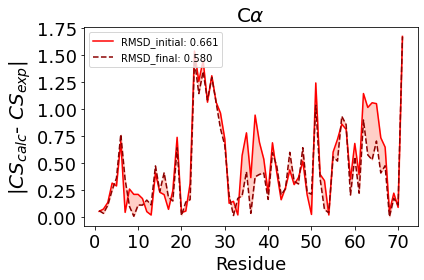

CB
RMSD_initial: 0.422 RMSD_final: 0.392


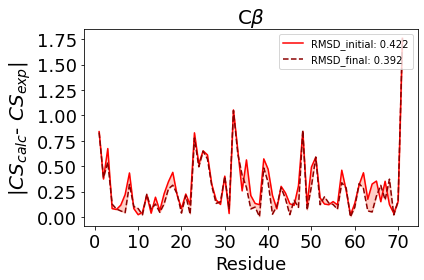

HA
RMSD_initial: 0.113 RMSD_final: 0.099


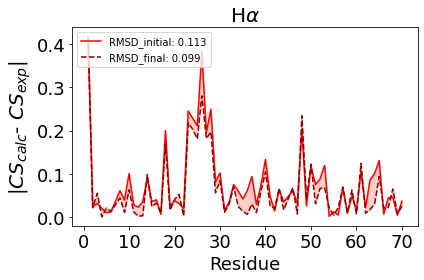

H
RMSD_initial: 0.171 RMSD_final: 0.147


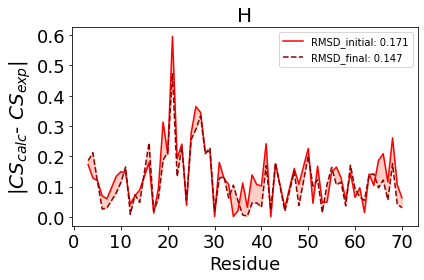

N
RMSD_initial: 0.985 RMSD_final: 0.840


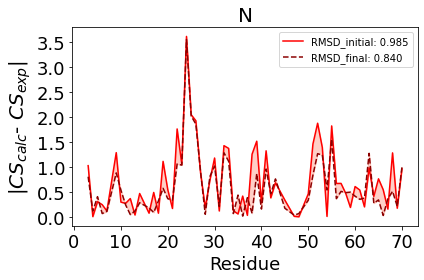

C
RMSD_initial: 0.644 RMSD_final: 0.562


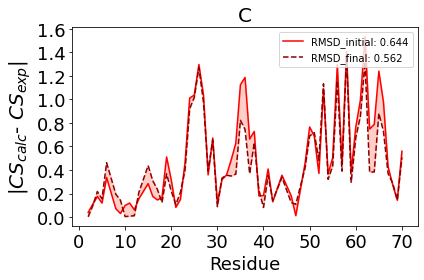

RDC
RMSD_initial: 4.087 RMSD_final: 3.650
RMSD initial scale: 4.087 RMSD final scale: 3.620
Q initial scale: 0.739 Q final scale: 0.655


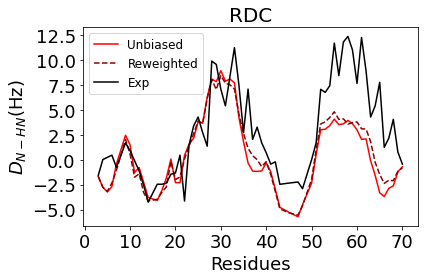

SAXS
RMSD_initial: 0.209 RMSD_final: 0.043


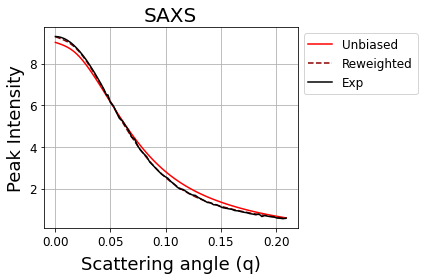

CA-CB-HA-H-N-C-RDC-SAXS Theta: 3.1663157894736838 Kish: 12.596492 RMSD initail: 1.4829 RMSD final: 1.3190
Initial RMSE reweight data 
 * Total :      1.483
 *    CA :      0.661
 *    CB :      0.422
 *    HA :      0.113
 *     H :      0.171
 *     N :      0.985
 *     C :      0.644
 *    RDC :      4.087
 *    RDC scaled Q:  0.739
 *    SAXS :      0.209
Final RMSE reweight data
 * Total :      1.319
 *    CA :      0.580
 *    CB :      0.392
 *    HA :      0.099
 *     H :      0.147
 *     N :      0.840
 *     C :      0.562
 *    RDC :      3.650
 *    RDC Q_scaled:  0.655
 *    SAXS :      0.043


In [19]:
To_Scan=combined_reweighting_keys


CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(To_Scan[0], true_exp_labels)
obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(Reweight_Data, expdata, compdata, theta_dict, sd, compare_dict_r)


s = '{:.2f}'.format(theta_m)

sigma_reg=theta_m*err_r
#sigma_md=sigma_md_r
sigma_md = np.zeros(len(sigma_md_r))

        

nobs_r = len(obs_exp_r)
nobs_v = len(obs_exp_v)
weight_bias=np.ones(nframes)
if 'RDC' in Reweight_Data:    
       initial_weights=weight_bias
       initial_weights/=np.sum(initial_weights)
       initial_obs_r=np.dot(traj_r,initial_weights)
       initial_obs_r
       exp_rdc=np.trim_zeros(obs_exp_r*data_r_type['RDC'])
       calc_rdc=np.trim_zeros(initial_obs_r*data_r_type['RDC'])
       qi_pos,rms_i_pos,qf_pos,rms_f_pos,rdc_scale_pos,c_pos=scale_rdc_Q(exp_rdc,calc_rdc)
       #print(qi_pos,rms_i_pos,qf_pos,rms_f_pos,rdc_scale_pos,c_pos)    
       qi_neg,rms_i_neg,qf_neg,rms_f_neg,rdc_scale_neg,c_neg=scale_rdc_Q(-exp_rdc,calc_rdc)
       #print(qi_neg,rms_i_neg,qf_neg,rms_f_neg,rdc_scale_neg,c_neg)

       if(qf_neg<qf_pos):
        c=-c_neg
       else: 
        c=c_pos
    
       RDC_rows=np.where(data_r_type['RDC']==1)
       traj_r[RDC_rows]=traj_r[RDC_rows]*c


res = sp.optimize.minimize(func_sigma_reg_sigma_md, args = (traj_r, obs_exp_r, weight_bias, sigma_reg,sigma_md), x0 =  np.zeros((nobs_r,)), method='L-BFGS-B',jac=True)
initial_weights = Normalize_Weights(weight_bias)
initial_obs_r=np.dot(traj_r,initial_weights)
final_weights = Normalize_Weights(weight_bias-np.dot(res.x,traj_r))
final_obs_r=np.dot(traj_r,final_weights)
Ks_b = np.average(initial_weights)**2/np.average(initial_weights**2)
Ks_a = np.average(final_weights)**2/np.average(final_weights**2)
        
Kish_ratio = (Ks_a/Ks_b)*100
RMSE_initial=np.sqrt(np.mean((initial_obs_r-obs_exp_r)**2))
RMSE_reweight=np.sqrt(np.mean((final_obs_r-obs_exp_r)**2))

plot_fitting_data(final_weights)
print_comb_results()

np.savetxt('%s/weights_final.dat' % (CS_dir), final_weights, fmt=" %6.12lf")
# print final weights to file

f = open("%s/weights_final.a.dat" % CS_dir, "w")
for w in final_weights:
       f.write("%e\n" % w)
f.close()

### MAKING THE KEYS FOR CROSS-VALIDATION REWEIGHTING BY LEAVING ONE DATATYPE AT A TIME
- We want to now do a cross-validation test where we reweight a combination of data at a time by leaving one particular data-type out each time.
- We generate a new set of 'reweighting keys' to do this here

In [20]:
new_rwt_keys = []
for i in range(len(reweighting_keys)):
    new_list = reweighting_keys.copy()
    del new_list[i]
    new_rwt_keys.append(new_list)

### DOING A SCAN TO FIND OPTIMAL PARAMETERS FOR CROSS-VALIDATION
- For each key (which is a different combination of data-types each time) we run a scan of a range of $\sigma_{reg}$ values
- The process is exactly same as before where we iterate over each key and each $\sigma_{reg}$ value
- We store the RMSE and Kish score values for each iteration in new dictionaries `RMSE_leave_one_dict` and `Kishscan_leave_one_out`

In [21]:
To_Scan = new_rwt_keys
thetas = np.linspace(0.01, 20, 20)
ref_theta = thetas[-1]
RMSE_leave_one_dict = {}
KishScan_leave_one_out = {}
for CS in To_Scan:
    CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
    KishScan_leave_one_out[CS] = {}
    print('Reweight Data = {}'.format(CS))
    RMSE_leave_one_dict[CS] = {}

    compare = []
    compare_dict_r = {key: {} for key in compdata.keys()}
    compare_dict_v = {key: {} for key in compdata.keys()}

    ####### B) The reweighting procedure

    obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(Reweight_Data, expdata, compdata, theta_dict, sd, compare_dict_r)
    obs_exp_v, traj_v, err_v, sigma_md_v, data_v_t, data_v_type, compare_dict_v = Process_Data_Into_Arrays_with_sigma(Validation_Data, expdata, compdata, theta_0, sd, compare_dict_v)

    # THETA CYCLE
    theta_list = []
    kish_list = []
    rmsd_f_list = []
    for theta_m in np.flip(thetas):

        s = '{:.2f}'.format(theta_m)
        sigma_reg = theta_m * err_r
        # sigma_md = sigma_md_r
        sigma_md = np.zeros(len(sigma_md_r))
        RMSE_leave_one_dict[CS][s] = {}

        # iv) Print dimensions
        nobs_r = len(obs_exp_r)
        nobs_v = len(obs_exp_v)
        # Print_Number_of_Data(nframes, nobs_r, nobs_v, data_r_type, data_v_type)

        # v) perform minimization
        # OBS: res.X = lagrange multiplier
        weight_bias = np.ones(nframes)

        if 'RDC' in Reweight_Data:
            initial_weights = weight_bias
            initial_weights /= np.sum(initial_weights)
            initial_obs_r = np.dot(traj_r, initial_weights)
            initial_obs_r
            exp_rdc = np.trim_zeros(obs_exp_r * data_r_type['RDC'])
            calc_rdc = np.trim_zeros(initial_obs_r * data_r_type['RDC'])
            qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
            qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

            if (qf_neg < qf_pos):
                c = -c_neg
            else:
                c = c_pos

            RDC_rows = np.where(data_r_type['RDC'] == 1)
            traj_r[RDC_rows] = traj_r[RDC_rows] * c

        if 'RDC' in Validation_Data:
            initial_weights = weight_bias
            initial_weights /= np.sum(initial_weights)
            initial_obs_v = np.dot(traj_v, initial_weights)
            exp_rdc = np.trim_zeros(obs_exp_v * data_v_type['RDC'])
            calc_rdc = np.trim_zeros(initial_obs_v * data_v_type['RDC'])
            qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
            qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

            if (qf_neg < qf_pos):
                c = -c_neg
            else:
                c = c_pos

            RDC_rows = np.where(data_v_type['RDC'] == 1)
            traj_v[RDC_rows] = traj_v[RDC_rows] * c

        res = sp.optimize.minimize(func_sigma_reg_sigma_md,
                                    args=(traj_r, obs_exp_r, weight_bias, sigma_reg, sigma_md),
                                    x0=np.zeros((nobs_r,)), method='L-BFGS-B', jac=True)
        initial_weights = Normalize_Weights(weight_bias)
        initial_obs_r = np.dot(traj_r, initial_weights)
        initial_obs_v = np.dot(traj_v, initial_weights)

        final_weights = Normalize_Weights(weight_bias - np.dot(res.x, traj_r))
        final_obs_r = np.dot(traj_r, final_weights)
        final_obs_v = np.dot(traj_v, final_weights)
        # g) calculating Kish effective size
        Ks_b = np.average(initial_weights) ** 2 / np.average(initial_weights ** 2)
        Ks_a = np.average(final_weights) ** 2 / np.average(final_weights ** 2)

        Kish_ratio = (Ks_a / Ks_b) * 100
        RMSE_initial = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))
        RMSE_reweight = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))

        theta_list.append(theta_m)
        kish_list.append(Kish_ratio)
        rmsd_f_list.append(RMSE_reweight)
        RMSE_r_i = {}
        RMSE_v_i = {}
        RMSE_r_f = {}
        RMSE_v_f = {}
        RMSE_r_i['Tot'] = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))

        for t in data_r_type:
            RMSE_r_i[t] = np.sqrt(
                np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
            if str(t) == 'RDC':
                qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_r * data_r_type['RDC'],
                                                                    obs_exp_r * data_r_type['RDC'])
                RMSE_r_i['RDC'] = qf

        RMSE_v_i['Tot'] = np.sqrt(
            np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
        for t in data_v_type:
            RMSE_v_i[t] = np.sqrt(
                np.sum((initial_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t]))
            if str(t) == 'RDC':
                qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_v * data_v_type['RDC'],
                                                                    obs_exp_v * data_v_type['RDC'])
                RMSE_v_i['RDC'] = qf

        RMSE_r_f['Tot'] = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))

        for t in data_r_type:
            RMSE_r_f[t] = np.sqrt(np.sum((final_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
            if str(t) == 'RDC':
                qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(final_obs_r * data_r_type['RDC'],
                                                                    obs_exp_r * data_r_type['RDC'])
                RMSE_r_f['RDC'] = qf

        for t in data_v_type:
            RMSE_v_f[t] = np.sqrt(np.sum((final_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t]))
            if str(t) == 'RDC':
                qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(final_obs_v * data_v_type['RDC'],
                                                                    obs_exp_v * data_v_type['RDC'])
                RMSE_v_f['RDC'] = qf

        RMSE_leave_one_dict[CS][s]['Kish'] = Kish_ratio
        RMSE_leave_one_dict[CS][s]['r_i'] = RMSE_r_i
        RMSE_leave_one_dict[CS][s]['r_f'] = RMSE_r_f
        RMSE_leave_one_dict[CS][s]['v_i'] = RMSE_v_i
        RMSE_leave_one_dict[CS][s]['v_f'] = RMSE_v_f

    KishScan_leave_one_out[CS]['kish'] = np.column_stack((theta_list, kish_list))
    KishScan_leave_one_out[CS]['rmsd'] = np.column_stack((theta_list, rmsd_f_list))

Reweight Data = CB-HA-H-N-C-RDC-SAXS
Reweight Data = CA-HA-H-N-C-RDC-SAXS
Reweight Data = CA-CB-H-N-C-RDC-SAXS
Reweight Data = CA-CB-HA-N-C-RDC-SAXS
Reweight Data = CA-CB-HA-H-C-RDC-SAXS
Reweight Data = CA-CB-HA-H-N-RDC-SAXS
Reweight Data = CA-CB-HA-H-N-C-SAXS
Reweight Data = CA-CB-HA-H-N-C-RDC


### FINDING OPTIMAL PARAMETER VALUE FOR CROSS-VALIDATION REWEIGHTING

This code iterates through `KishScan_leave_one_out` to find a `theta_m` that meets a minimum Kish ratio (`kish_min`). It selects the last `theta_m` value above `kish_min` and, if zero, uses the second-to-last value.

#### Process:
- **Initialization:**
  - `kish_min = 10`: Minimum threshold for the Kish ratio.
  - `theta_dict`: Dictionary to store selected `theta_m` values for each `key` in `KishScan_combined`.
  - `Kish_ratio_vals`: List to collect `theta_m` values meeting the `kish_min` criteria.

- **Iteration:**
  - For each `key` in `KishScan_leave_one_out`:
    - Retrieve Kish ratios (`kish`) from `KishScan_leave_one_out[key]['kish']`.
    - Identify indices (`b`) where Kish ratio meets or exceeds `kish_min`.
    - Select `theta_m` as the last valid value (so lowest value) from `kish` that meets the criteria.
    - If `theta_m` is zero, fallback to the second-to-last valid value (`k[idy][0]`).
    - Store `theta_m` in `theta_dict_leave_one[key]`.

- **Output:**
  - `theta_dict_leave_one`: Dictionary mapping each key to the selected `theta_m` that meets the `kish_min` criteria.


In [22]:
kish_min = 10
theta_dict_leave_one = {}
Kish_ratio_vals = []
for key in KishScan_leave_one_out:
    k = KishScan_leave_one_out[key]['kish']
    b = (np.where(k[:, 1] >= kish_min))[0]
    idx = b[-1]
    idy = b[-2]
    theta_m = k[idx][0]
    Kish_ratio_vals.append(theta_m)
    if (theta_m == 0):
        theta_m = k[idy][0]
    theta_dict_leave_one[key] = {}
    theta_dict_leave_one[key] = (theta_m)

### CROSS-VALIDATION REWEIGHTING WITH OPTIMAL PARAMETERS

- We found optimal $\sigma_{reg}$ values above
- We do a final reweighting process on the combined data with that optimal parameter value
- We save the final weights into the output directory


In [23]:
 To_Scan = new_rwt_keys

for CS in To_Scan:
    CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
    print('Reweight Data = {}'.format(CS))
    CS_dir = join(leave_dir, CS)
    if not os.path.exists(CS_dir):
        os.makedirs(CS_dir)

    compare = []
    compare_dict_r = {key: {} for key in compdata.keys()}
    compare_dict_v = {key: {} for key in compdata.keys()}

    obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(
        Reweight_Data, expdata, compdata, theta_dict, sd, compare_dict_r)
    obs_exp_v, traj_v, err_v, sigma_md_v, data_v_t, data_v_type, compare_dict_v = Process_Data_Into_Arrays_with_sigma(
        Validation_Data, expdata, compdata, theta_0, sd, compare_dict_v)

    theta_m = theta_dict_leave_one[CS]
    s = '{:.2f}'.format(theta_m)
    print(s)
    sigma_reg = theta_m * err_r
    # sigma_md = sigma_md_r
    sigma_md = np.zeros(len(sigma_md_r))

    # iv) Print dimensions
    nobs_r = len(obs_exp_r)
    nobs_v = len(obs_exp_v)

    # v) perform minimization
    # OBS: res.X = lagrange multiplier
    weight_bias = np.ones(nframes)
    if 'RDC' in Reweight_Data:
        intial_weights = weight_bias
        initial_weights /= np.sum(initial_weights)
        initial_obs_r = np.dot(traj_r, initial_weights)
        initial_obs_r
        exp_rdc = np.trim_zeros(obs_exp_r * data_r_type['RDC'])
        calc_rdc = np.trim_zeros(initial_obs_r * data_r_type['RDC'])
        qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
        qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

        if (qf_neg < qf_pos):
            c = -c_neg
        else:
            c = c_pos
        RDC_rows = np.where(data_r_type['RDC'] == 1)
        traj_r[RDC_rows] = traj_r[RDC_rows] * c

    if 'RDC' in Validation_Data:
        intial_weights = weight_bias
        initial_weights /= np.sum(initial_weights)
        initial_obs_v = np.dot(traj_v, initial_weights)
        initial_obs_v
        exp_rdc = np.trim_zeros(obs_exp_v * data_v_type['RDC'])
        calc_rdc = np.trim_zeros(initial_obs_v * data_v_type['RDC'])
        qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
        qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

        if (qf_neg < qf_pos):
            c = -c_neg
        else:
            c = c_pos
        RDC_rows = np.where(data_v_type['RDC'] == 1)
        traj_v[RDC_rows] = traj_v[RDC_rows] * c

    res = sp.optimize.minimize(func_sigma_reg_sigma_md, args=(traj_r, obs_exp_r, weight_bias, sigma_reg, sigma_md),
                                x0=np.zeros((nobs_r,)), method='L-BFGS-B', jac=True)
    initial_weights = Normalize_Weights(weight_bias)
    initial_obs_r = np.dot(traj_r, initial_weights)
    initial_obs_v = np.dot(traj_v, initial_weights)
    # if res.success: print("\nMinimization worked: {}\n".format(res.success))
    # else: raise ValueError('Minimization with {}, theta = {} as reweighting data did not worked!'.format(CS, s))
    final_weights = Normalize_Weights(weight_bias - np.dot(res.x, traj_r))
    # e) final average observables for reweighting and validation
    final_obs_r = np.dot(traj_r, final_weights)
    final_obs_v = np.dot(traj_v, final_weights)
    # g) calculating Kish effective size
    Ks_b = np.average(initial_weights) ** 2 / np.average(initial_weights ** 2)
    Ks_a = np.average(final_weights) ** 2 / np.average(final_weights ** 2)
    # print("Initial Kish size : %9.6lf %d" % (Ks_b, Ks_b*nframes))
    # print("Reweighted Kish size : %9.6lf %d" % (Ks_a, Ks_a*nframes))
    Kish_ratio = (Ks_a / Ks_b) * 100
    RMSE_initial = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))
    RMSE_reweight = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))

    #     plot_fitting_data(final_weights)

    print(CS, "Theta:", theta_m, "Kish: %9.6lf" % (Kish_ratio), "RMSD initail: %0.4f" % RMSE_initial,
            "RMSD final: %0.4f" % RMSE_reweight)

    print("Initial RMSE reweight data ")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2)))

    for t in data_r_type:
        print(" *    %2s :" % t, end='')
        print("     %6.3lf" % np.sqrt(
            np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t])))

        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_r * data_r_type['RDC'],
                                                                obs_exp_r * data_r_type['RDC'])
            # print(" *    RDC scaled RMSD:", end = '')
            # print(" %6.3lf" % rms_f)
            print(" *    RDC scaled Q:", end='')
            print(" %6.3lf" % qf)

    print("Initial RMSE validation data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_v - obs_exp_v) ** 2)))

    for t in data_v_type:
        print(" *    %2s :" % t, end='')
        # (initial_obs_v-obs_exp_v)**2*data_v_type[t])
        print("     %6.3lf" % np.sqrt(
            np.sum((initial_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t])))
        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_v * data_v_type['RDC'],
                                                                obs_exp_v * data_v_type['RDC'])
            # print(" *    RDC scaled RMSD:", end = '')
            # print(" %6.3lf" % rms_f)
            print(" *    RDC scaled Q:", end='')
            print(" %6.3lf" % qf)

    print("Final RMSE reweight data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2)))

    for t in data_r_type:
        print(" *    %2s :" % t, end='')
        print("     %6.3lf" % np.sqrt(
            np.sum((final_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t])))
        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdcs_scale_f, c = scale_rdc_Q(final_obs_r * data_r_type['RDC'],
                                                                obs_exp_r * data_r_type['RDC'])
            # print(" *    RDC RMSE_scale:", end = '')
            # print(" %6.3lf" % rms_f)
            print(" *    RDC Q_scaled:", end='')
            print(" %6.3lf" % qf)

    print("Final RMSE validation data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_v - obs_exp_v) ** 2)))

    for t in data_v_type:
        print(" *    %2s :" % t, end='')
        print("     %6.3lf" % np.sqrt(
            np.sum((final_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t])))
        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdc_scale_f, c = scale_rdc_Q(final_obs_v * data_v_type['RDC'],
                                                                obs_exp_v * data_v_type['RDC'])
            # print(" *    RDC RMSE_scale:", end = '')
            # print(" %6.3lf" % rms_f)
            print(" *    RDC Q_scaled:", end='')
            print(" %6.3lf" % qf)
    np.savetxt('%s/weights_final.dat' % (CS_dir), final_weights, fmt=" %6.12lf")
    # print final weights to file

    f = open("%s/weights_final.a.dat" % CS_dir, "w")
    for w in final_weights:
        f.write("%e\n" % w)
    f.close()

Reweight Data = CB-HA-H-N-C-RDC-SAXS
3.17
CB-HA-H-N-C-RDC-SAXS Theta: 3.1663157894736838 Kish: 16.512845 RMSD initail: 1.5701 RMSD final: 1.4282
Initial RMSE reweight data 
 * Total :      1.570
 *    CB :      0.422
 *    HA :      0.113
 *     H :      0.171
 *     N :      0.985
 *     C :      0.644
 *    RDC :      4.087
 *    RDC scaled Q:  0.739
 *    SAXS :      0.209
Initial RMSE validation data
 * Total :      0.661
 *    CA :      0.661
Final RMSE reweight data
 * Total :      1.428
 *    CB :      0.393
 *    HA :      0.100
 *     H :      0.148
 *     N :      0.847
 *     C :      0.579
 *    RDC :      3.735
 *    RDC Q_scaled:  0.672
 *    SAXS :      0.042
Final RMSE validation data
 * Total :      0.602
 *    CA :      0.602
Reweight Data = CA-HA-H-N-C-RDC-SAXS
3.17
CA-HA-H-N-C-RDC-SAXS Theta: 3.1663157894736838 Kish: 13.730569 RMSD initail: 1.5825 RMSD final: 1.4147
Initial RMSE reweight data 
 * Total :      1.583
 *    CA :      0.661
 *    HA :      0.113
 *     

### SAVING ALL THE INFORMATION FROM THE OPTIMIZED REWEIGHTING ROUNDS AS DICTIONARIES TO LOAD FOR MAKING THE ANALYSIS PLOTS

In [24]:
import pickle

with open('%s/RMSE_single.pkl' % dic_dir, 'wb') as fp:
    pickle.dump(RMSE_dict, fp)

with open('%s/RMSE_leave_one.pkl' % dic_dir, 'wb') as fp:
    pickle.dump(RMSE_leave_one_dict, fp)

with open('%s/RMSE_combined.pkl' % dic_dir, 'wb') as fp:
    pickle.dump(RMSE_dict_combined, fp)

with open('%s/theta_dict.pkl' % dic_dir, 'wb') as fp:
    pickle.dump(theta_dict, fp)

with open('%s/theta_dict_combined.pkl' % dic_dir, 'wb') as fp:
    pickle.dump(theta_dict_combined, fp)

with open('%s/theta_dict_leave_one.pkl' % dic_dir, 'wb') as fp:
    pickle.dump(theta_dict_leave_one, fp)

with open('%s/KishScan_single_data.pkl' % dic_dir, 'wb') as fp:
    pickle.dump(KishScan_one_data, fp)

with open('%s/KishScan_leave_one.pkl' % dic_dir, 'wb') as fp:
    pickle.dump(KishScan_leave_one_out, fp)

with open('%s/KishScan_combined.pkl' % dic_dir, 'wb') as fp:
    pickle.dump(KishScan_combined, fp)

with open('%s/colors.pkl' % dic_dir, 'wb') as fp:
    pickle.dump(colors, fp)